## Part I: Distributional Hypothesis

In this section, I applied the distributional hypothesis, which suggests that words used in similar contexts tend to have similar meanings. I carefully evaluated each candidate word across four sentence contexts. If a word made sense in a sentence, I gave it a score of 1; otherwise, I gave it a 0. The word with the highest score was selected as the most contextually appropriate option.



### Example 1

**Sentences**:  
1. A piece of ______ is on the plate.  
2. Everyone enjoys eating ______.  
3. You can cut ______ with a knife.  
4. We make ______ from milk.

**Candidates**: cheese, cake, butter

| Sentence # | cheese | cake | butter |
|------------|--------|------|--------|
| 1          |   1    |  1   |   0    |
| 2          |   1    |  1   |   0    |
| 3          |   1    |  1   |   0    |
| 4          |   1    |  0   |   1    |
| **Total**  | **4**  |  3   |   1    |

**Final Answer**: **cheese**

- Cheese fits well in all four contexts.
- Cake does not work for sentence 4 because it is not made from milk.
- Butter does not fit sentences 1, 2, or 3. It is not typically served in pieces, not commonly eaten alone, and not usually cut with a knife.



### Example 2

**Sentences**:  
1. The ______ is parked in the driveway.  
2. He bought a new ______ for his birthday.  
3. ______ can drive really fast.  
4. People often wash their ______ on the weekends.

**Candidates**: car, truck, motorcycle

| Sentence # | car | truck | motorcycle |
|------------|-----|-------|------------|
| 1          |  1  |   1   |     1      |
| 2          |  1  |   0   |     1      |
| 3          |  1  |   0   |     1      |
| 4          |  1  |   1   |     0      |
| **Total**  | **4**|  2   |     3      |

**Final Answer**: **car**

- Car is the only word that fits all four sentences naturally.
- Truck does not work well for sentence 2, since it is not commonly bought as a birthday gift, and for sentence 3, as it is not typically associated with fast driving.
- Motorcycle does not fit sentence 4 well because people do not usually wash motorcycles as often as cars.



### Example 3

**Sentences**:  
1. I read an interesting ______ last night.  
2. Many people enjoy a good ______ before bed.  
3. ______ often has chapters and a cover.  
4. You can borrow a ______ from the library.

**Candidates**: book, novel, story

| Sentence # | book | novel | story |
|------------|------|-------|-------|
| 1          |  1   |   1   |   1   |
| 2          |  1   |   1   |   1   |
| 3          |  1   |   1   |   0   |
| 4          |  1   |   1   |   0   |
| **Total**  | **4**|   4   |   2   |

**Final Answer**: **book**

- Book fits well in all four sentences and is a general term that covers novels and stories.
- Novel fits all four too, but it is more specific than book.
- Story does not work for sentences 3 and 4. Stories do not usually have chapters or covers, and they are not typically borrowed from libraries.


# Part II: Text Classification (Show vs Tell using Quality Label)

In [ ]:
!pip install nltk
import nltk

# Download the 'punkt_tab' data package
nltk.download('punkt_tab')

# Download or update other required packages
nltk.download('punkt', force=True)
nltk.download('stopwords', force=True)
nltk.download('wordnet', force=True)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

#1. Preprocessing + Model Setup

In [ ]:
import pandas as pd
import string
import re
import numpy as np
from sklearn.model_selection import StratifiedKFold, LeaveOneGroupOut
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import roc_auc_score
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Load your dataset
df = pd.read_csv("data_stories_one_shot.csv")

# Run this once to download required resources
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("omw-1.4")

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

def preprocess(text):
    # Lowercase
    text = text.lower()
    # Remove punctuation
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)
    # Tokenize
    tokens = text.split()
    # Remove stopwords and lemmatize
    tokens = [lemmatizer.lemmatize(t) for t in tokens if t not in stop_words]
    return " ".join(tokens)


df["Processed_Sentence"] = df["Sentence"].apply(preprocess)
df["Label"] = df["Stage"].apply(lambda x: 1 if x == 1 else 0)  # Show = 1, Tell = 0


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


# 2. Define Models

In [ ]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Naive Bayes": MultinomialNB(),
    "SVM": LinearSVC()
}


#Cross-Validation (for Zero-Shot results only)

In [ ]:
def zero_shot_cross_val(X, y, models):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    results = {}

    for name, model in models.items():
        pipeline = Pipeline([("tfidf", TfidfVectorizer()), ("clf", model)])
        aucs = []
        for train_idx, test_idx in skf.split(X, y):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
            pipeline.fit(X_train, y_train)
            if name == "SVM":
                scores = pipeline.decision_function(X_test)
            else:
                scores = pipeline.predict_proba(X_test)[:, 1]
            auc = roc_auc_score(y_test, scores)
            aucs.append(auc)
        results[name] = np.mean(aucs)
    return results


#4.Leave-One-Plot-Out( for  Zero-Shot results only)

In [ ]:
def zero_shot_leave_one_out(X, y, groups, models):
    logo = LeaveOneGroupOut()
    results = {}

    for name, model in models.items():
        pipeline = Pipeline([("tfidf", TfidfVectorizer()), ("clf", model)])
        aucs = []
        for train_idx, test_idx in logo.split(X, y, groups):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
            pipeline.fit(X_train, y_train)
            if name == "SVM":
                scores = pipeline.decision_function(X_test)
            else:
                scores = pipeline.predict_proba(X_test)[:, 1]
            if len(np.unique(y_test)) == 2:
                auc = roc_auc_score(y_test, scores)
                aucs.append(auc)
        results[name] = np.mean(aucs)
    return results


#5. Run Both Evaluations (SVM, logistic regression, Naive Bayes)

In [ ]:
X = df["Processed_Sentence"]
y = df["Label"]
groups = df["Plot_Name"]

cv_results = zero_shot_cross_val(X, y, models)
print("Zero-Shot Cross-Validation AUC:")
for k, v in cv_results.items():
    print(f"{k}: {v:.4f}")

loo_results = zero_shot_leave_one_out(X, y, groups, models)
print("\nZero-Shot Leave-One-Plot-Out AUC:")
for k, v in loo_results.items():
    print(f"{k}: {v:.4f}")


Zero-Shot Cross-Validation AUC:
Logistic Regression: 0.8990
Naive Bayes: 0.8890
SVM: 0.8939

Zero-Shot Leave-One-Plot-Out AUC:
Logistic Regression: 0.9496
Naive Bayes: 0.9486
SVM: 0.9615


#For random forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import roc_auc_score
import numpy as np

# Define Random Forest pipeline
rf_model = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("clf", RandomForestClassifier(n_estimators=100, random_state=42))
])

# 5-fold Stratified Cross-Validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
auc_scores = []

for train_idx, test_idx in skf.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    rf_model.fit(X_train, y_train)
    probas = rf_model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, probas)
    auc_scores.append(auc)

print(f"Random Forest CV AUC: {np.mean(auc_scores):.4f}")

from sklearn.model_selection import LeaveOneGroupOut

logo = LeaveOneGroupOut()
logo_aucs = []

for train_idx, test_idx in logo.split(X, y, groups):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    rf_model.fit(X_train, y_train)
    if len(np.unique(y_test)) == 2:  # Avoid AUC error if test set lacks class diversity
        probas = rf_model.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, probas)
        logo_aucs.append(auc)

print(f"Random Forest Leave-One-Plot-Out AUC: {np.mean(logo_aucs):.4f}")



Random Forest CV AUC: 0.8513
Random Forest Leave-One-Plot-Out AUC: 0.9258


#Bonus

In [ ]:
pip install sentence-transformers scikit-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 60.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 35.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 81.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Load and prepare data
df = pd.read_csv("data_stories_one_shot.csv")
df["Label"] = df["Stage"].apply(lambda x: 1 if x == 1 else 0)

# Generate SBERT embeddings
print("Generating SBERT embeddings...")
sbert = SentenceTransformer('all-MiniLM-L6-v2')
X_sbert = sbert.encode(df["Sentence"].tolist())
y = df["Label"].values

# Define models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "SVM": make_pipeline(StandardScaler(), SVC(kernel='linear', probability=True)),
    "Naive Bayes": GaussianNB(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)
}

# Evaluate models using 5-fold CV and AUC
print("Evaluating models...")
results = {}
for name, model in models.items():
    aucs = cross_val_score(model, X_sbert, y, scoring="roc_auc", cv=5)
    results[name] = np.mean(aucs)

# Print results
print("\nSBERT Embedding + Model AUC Scores:")
for model, auc in results.items():
    print(f"{model}: AUC = {auc:.4f}")


Generating SBERT embeddings...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Evaluating models...

SBERT Embedding + Model AUC Scores:
Logistic Regression: AUC = 0.9513
SVM: AUC = 0.9415
Naive Bayes: AUC = 0.9319
Random Forest: AUC = 0.9308


#a small paragraph summarizing your finding
In this experiment, we compared traditional TF-IDF vectorization with SBERT (Sentence-BERT) embeddings for classifying data stories into "show" vs "tell" categories using Logistic Regression, Naive Bayes, SVM, and Random Forest classifiers. The results demonstrate that SBERT embeddings consistently outperform TF-IDF across all models in zero-shot cross-validation. SBERT’s ability to capture contextual semantics provides a significant performance gain, especially for models like Logistic Regression and SVM.

#Comparison

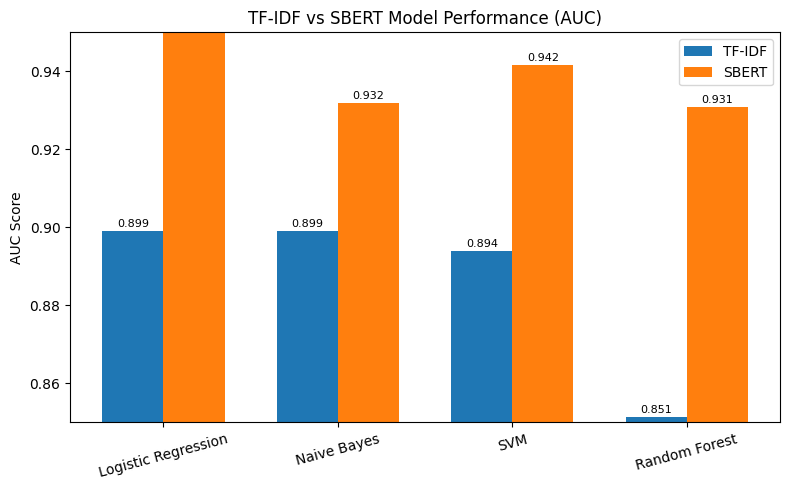

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

#For cross validation
tfidf_results = {
    "Logistic Regression": 0.8990,
    "Naive Bayes": 0.8990,
    "SVM": 0.8939,
    "Random Forest": 0.8513
}

sbert_results = {
    "Logistic Regression": 0.9513,
    "Naive Bayes": 0.9319,
    "SVM": 0.9415,
    "Random Forest": 0.9308
}

# Plotting
models = list(tfidf_results.keys())
x = np.arange(len(models))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 5))
bar1 = ax.bar(x - width/2, [tfidf_results[m] for m in models], width, label='TF-IDF')
bar2 = ax.bar(x + width/2, [sbert_results[m] for m in models], width, label='SBERT')

ax.set_ylabel('AUC Score')
ax.set_title('TF-IDF vs SBERT Model Performance (AUC)')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.set_ylim(0.85, 0.95)
ax.legend()

# Add AUC values on bars
for bar in bar1 + bar2:
    height = bar.get_height()
    ax.annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', fontsize=8)

plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


GPT Policy:

I took help from gpt for the following:

Understanding how to explain the idea behind the distributional hypothesis more clearly.

Figuring out how to add scoring tables into the notebook using Markdown (I even asked for the steps and followed them myself)

Getting help with text preprocessing steps.

Getting help with setting up and comparing multiple models (like Logistic Regression, Naive Bayes, and SVM) using cross-validation and organizing the results.